## Preprocess data in successive stages
- [1. Doublecheck no duplicate samples](#Check_No_duplicates)
- [2. Filter by min genes, % mito, % unusabe reads](#Basic_filters)
- [3. Run full clustering + UMAP pipeline to identify and filter MDCKs](#Filter_mdcks)
    - [3b. Actually execute the filter](#Filter_mdcks2)
- [4. Run full clustering + UMAP pipeline after filtering MDCKs](#UMAP_Cluster)
- [5. Sub-cluster myeloid + BOD](Subcluster/MonoSubcluster.InVivo.Seqwell.gene_30020191205.ipynb#Subcluster_myeloid)
- [6. Sub-cluster T + NK](Subcluster/T_Subcluster.InVivo.Seqwell.gene_30020191205.ipynb#Subcluster_TandNK)

In [1]:
import os

adir = '../../../../data/InVivo/Seqwell/'
project_name = 'invivo_all_20200318_mmul8_V4_fixid'
gcs = False

results_dir = '../../../../results'

abase = os.path.join(adir, project_name)
abase

'../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata

import palettable
from IPython.display import display

from joblib import parallel_backend
from scipy.stats import ranksums
from harmony import harmonize
from statsmodels.stats.multitest import multipletests

import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(14)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


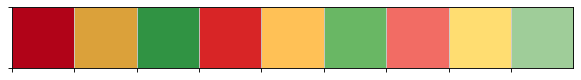

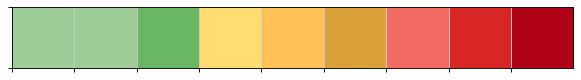

In [5]:
dpi_colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(dpi_colors)
sns.palplot(dpi_colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dpi_colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap['0'] = palettable.tableau.TableauMedium_10.mpl_colors[-1]

dpi_colors2 = np.array([x for x in palettable.tableau.TrafficLight_9.hex_colors])
dpimap2 = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dpi_colors2[[8,8,5, 7, 4, 1, 6,3,0]]))
dpimap2['0'] = palettable.tableau.TableauMedium_10.hex_colors[-1]

<a id=Check_No_duplicates></a>
## Doublecheck no duplicate samples


In [6]:
results_raw_file = os.path.join(adir, project_name + '_raw.h5ad')
results_raw_file

'../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid_raw.h5ad'

In [7]:
adata = read_adata(results_raw_file, gcs=gcs)

In [8]:
adata.uns['DPIc_colors'] = [dpimap2[str(x)] for x in [0,3,4,5,6,7,8]]

In [9]:
adata.obs.columns

Index(['batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status',
       'sample_source', 'sample', 'array_num', 'array_id', 'animal',
       'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP',
       'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short',
       'PCT_USABLE_BASES', 'PCT_MRNA_BASES'],
      dtype='object')

In [10]:
adata.obs.head()

batch  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   

                                                    DPI DPIc    Period  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   

                                                                   full_sample_id  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1.DASH1-std   

                                                   frz_status sample_source  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   

                                                              sample  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh   

                                                   array_num  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...        a1   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...        a1   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...        a1   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...        a1   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...        a1   

                                                               array_id  ...  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1  ...   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1  ...   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1  ...   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1  ...   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.a1  ...   

                                                               sample_dash  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.mixed   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.mixed   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.mixed   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.mixed   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  NHP13.D000.fresh.mixed   

                                                         Barcode  BP  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  AAAAAAAAAAAA  88   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  AAAAACCGAAGT  88   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...  AAA

In [11]:
adata.obs['array_id'] = adata.obs['full_sample_id'].apply(lambda x: '.'.join(x.split('.')[:-1]))
adata.obs[['array_id', 'full_sample_id']].drop_duplicates()['array_id'].value_counts().head()

NHPC1.D-30.fresh.a1       1
NHP15.D003.FRZ-MDCK.a1    1
NHP14.D003.FRZ-MDCK.a4    1
NHP14.D003.FRZ-MDCK.a5    1
NHP14.D003.FRZ-MDCK.a6    1
Name: array_id, dtype: int64

In [12]:
adata.obs['BP'].value_counts()

88    401481
Name: BP, dtype: int64

In [13]:
adata.obs['FullSeqRun'].value_counts()

NovaNext_Merged     80959
Novaseq_20190701    57584
Novaseq_20190711    57571
Novaseq_20190808    52748
Novaseq_20190809    52743
Novaseq_20190129    28732
Novaseq_20190530    23755
Novaseq_20190326    23679
Novaseq_20180906    19086
Novaseq_20180711     4624
Name: FullSeqRun, dtype: int64

In [14]:
adata.obs['DPIc'].value_counts()

6    124656
3     91018
0     85515
5     43101
4     38355
8      9454
7      9382
Name: DPIc, dtype: int64

In [15]:
adata.obs['frz_status'].value_counts()

FRZ      239638
fresh    161843
Name: frz_status, dtype: int64

In [16]:
adata.obs['animal'].value_counts()

NHP14    52561
NHP16    43151
NHP23    43138
NHP24    38393
NHP13    38380
NHP19    38355
NHP22    38346
NHP15    28687
NHP18     9558
NHP11     9556
NHP17     9546
NHP10     9489
NHPC1     9448
NHP08     9384
NHP09     9380
NHP20     4769
NHP12     4716
NHP07     4624
Name: animal, dtype: int64

In [17]:
adata.obs['animal'].unique().shape[0]

18

<a id="Basic_filters"></a>
## 2. Filter by min genes, % mito, % unusabe reads

In [18]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_genes(adata, min_cells=0)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


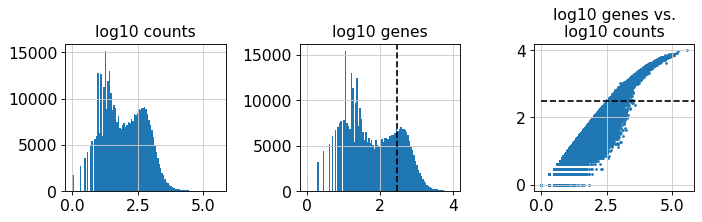

In [19]:
logncounts = adata.obs['n_counts'].apply(np.log10)
logngenes = adata.obs['n_genes'].apply(np.log10)

(fig,axes)= plt.subplots(1,3, figsize=(9,3))
axes[0].hist(logncounts,bins=100)
axes[1].hist(logngenes,bins=100)
axes[2].scatter(logncounts,logngenes, s=2)

ylim = axes[0].get_ylim()
axes[0].vlines(x=np.log10(count_thresh),ymin=0,ymax=ylim[1], linestyle='--')
axes[0].set_ylim(ylim)

ylim = axes[1].get_ylim()
axes[1].vlines(x=np.log10(gene_thresh),ymin=0,ymax=ylim[1], linestyle='--')
axes[1].set_ylim(ylim)

ylim = axes[2].get_ylim()
xlim = axes[2].get_xlim()
axes[2].vlines(x=np.log10(count_thresh),ymin=0,ymax=ylim[1], linestyle='--')
axes[2].hlines(y=np.log10(gene_thresh),xmin=0,xmax=xlim[1], linestyle='--')
axes[2].set_ylim(ylim)
axes[2].set_xlim(xlim)


axes[0].set_title('log10 counts')
axes[1].set_title('log10 genes')
axes[2].set_title('log10 genes vs.\nlog10 counts')
plt.tight_layout()

In [20]:
adata.shape

(401481, 24817)

In [21]:
sc.pp.filter_cells(adata, min_genes=gene_thresh)
sc.pp.filter_cells(adata, min_counts=count_thresh)
sc.pp.filter_genes(adata, min_cells=10)

filtered out 308898 cells that haveless than 300 genes expressed
filtered out 5681 genes that are detectedin less than 10 cells


In [22]:
adata

AnnData object with n_obs × n_vars = 92583 × 19136 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells'
    uns: 'DPIc_colors'

In [23]:
ebov_genes = adata.var.index[adata.var['gene_id'].apply(lambda x: 'EBOV' in x)]

adata.obs['EBOV_counts'] = np.sum(
    adata[:, ebov_genes].X, axis=1).A1


adata.obs['num_EBOV_genes'] = np.sum(
    adata[:, ebov_genes].X>0, axis=1).A1
# add the total counts per cell as observations-annotation to adata

adata.obs['percent_EBOV'] = adata.obs['EBOV_counts'] / adata.obs['n_counts']
adata.obs['EBOV_TPT'] = (adata.obs['EBOV_counts'] / adata.obs['n_counts']) * 10000
adata.obs['log10_EBOV_TPT'] = (adata.obs['EBOV_TPT']+1).apply(np.log10)

In [24]:
gtffn = 'gs://seqwell/data/references/Rhesus_Ebola_dropSeqPipe_v4_withStar88bp/MmulKitwit_8_92/annotation.gtf'
gtf = pd.read_csv(gtffn, sep='\t', header=None)
gtf[0] = gtf[0].astype(str)
gtf.head()

mito_genes = list(gtf.loc[gtf[0]=='MT',8].apply(lambda x: re.findall('gene_name "(.+?)";', x)[0]).unique())
mito_genes = [x.split('__')[1] for x in mito_genes]
mito_genes = list(set(mito_genes).intersection(set(adata.var['gene_symbol'])))

adata.obs['percent_mito'] = np.sum( 
    adata[:, mito_genes].X, axis=1).A1 / adata.obs['n_counts'].values


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(0.0, 8895.6)

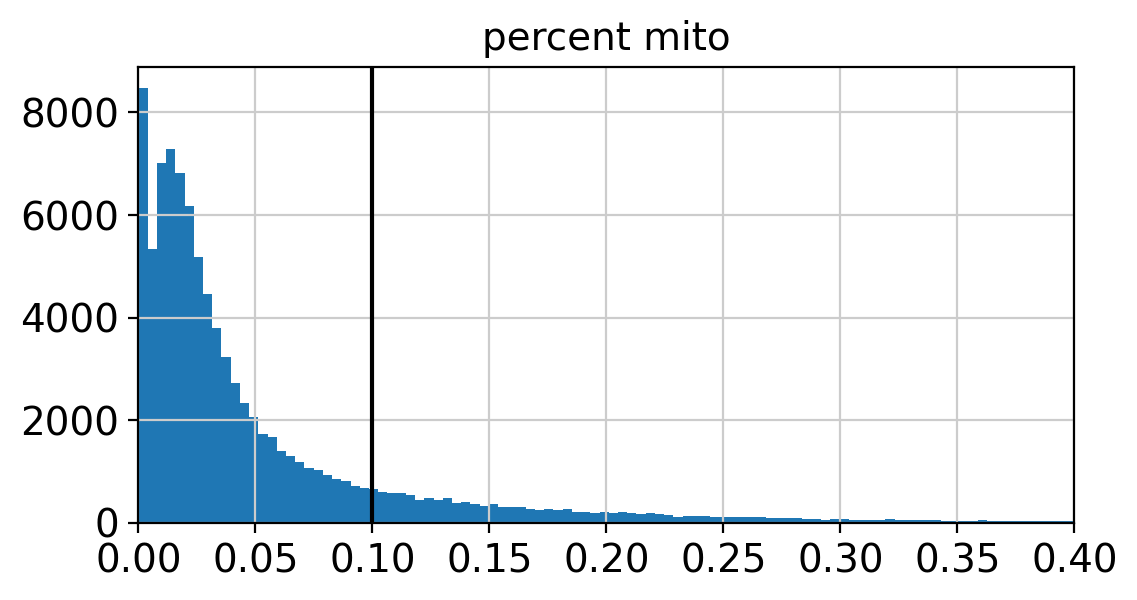

In [25]:
(fig,ax) = plt.subplots(1,1, figsize=(6,3), dpi=200)
ax.hist(adata.obs['percent_mito'], bins=200)
ax.set_title('percent mito')
ax.set_xlim([0,.4])
ylim = ax.get_ylim()
ax.vlines(x=mitothresh, ymin=ylim[0], ymax=ylim[1])
ax.set_ylim(ylim)

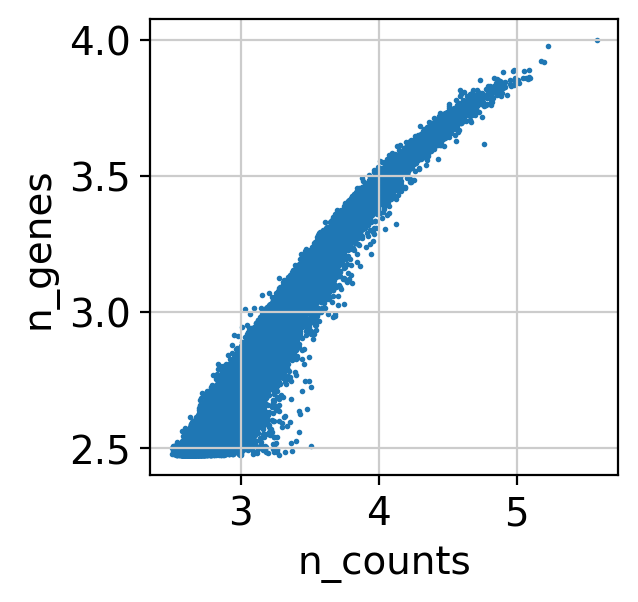

In [26]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(adata.obs['n_counts'].apply(np.log10),adata.obs['n_genes'].apply(np.log10), s=1)
ax.set_xlabel('n_counts')
ax.set_ylabel('n_genes')

xlim = ax.get_xlim()
#ax.hlines(y=np.log10(ngenethresh), xmin=xlim[0], xmax=xlim[1])
#ax.set_xlim(xlim)

In [27]:
(adata.obs['percent_mito']>mitothresh).sum(), (adata.obs['percent_mito']>mitothresh).mean()

(14093, 0.152220170009613)

In [28]:
adata.obs['PCT_UNUSABLE_BASES'] = 1 - adata.obs['PCT_USABLE_BASES']

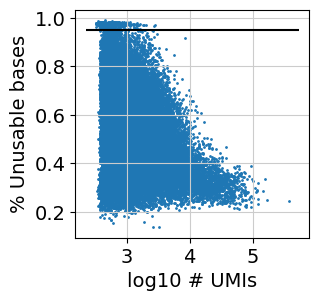

In [29]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=100)
ax.scatter(adata.obs['log_count'], adata.obs['PCT_UNUSABLE_BASES'], s=1)
ax.set_ylabel('% Unusable bases')
ax.set_xlabel('log10 # UMIs')
frac_unusable_thresh=.95
ax.hlines(y=frac_unusable_thresh, xmin=xlim[0], xmax=xlim[1])


Text(0.5, 0, 'PCT_UNUSABLE_BASES')

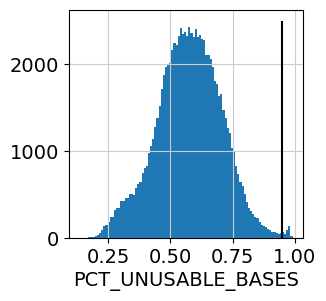

In [30]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=100)
_ = ax.hist(adata.obs['PCT_UNUSABLE_BASES'], bins=100)
ax.vlines(x=frac_unusable_thresh, ymin=0, ymax=2500)
ax.set_xlabel('PCT_UNUSABLE_BASES')

In [31]:
(adata.obs['PCT_UNUSABLE_BASES'] < frac_unusable_thresh).value_counts()

True     92247
False      336
Name: PCT_UNUSABLE_BASES, dtype: int64

In [32]:
X = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index)
X = X.div(X.sum(axis=1), axis=0)*10000
X = np.log(X+1)
R_mito = X.corrwith(adata.obs['percent_mito'], method='pearson')
R_mito.sort_values(ascending=False).head(50)

index
ENSMMUG00000028701    0.647892
COX3                  0.530945
ND1                   0.523352
ND5                   0.516837
CYTB                  0.511831
ENSMMUG00000045979    0.499047
COX2                  0.493433
ND4                   0.403804
ATP6                  0.394026
ENSMMUG00000038258    0.368084
ENSMMUG00000038428    0.273410
ND3                   0.245487
ENSMMUG00000041317    0.226628
CHD2                  0.222419
SCAPER                0.213270
ANKRD11               0.208346
ENSMMUG00000038177    0.198500
UTRN                  0.196876
BDP1                  0.196234
ND2                   0.195763
HBB                   0.193539
ND6                   0.191667
PRPF4B                0.190708
PRRC2C                0.187629
LUC7L3                0.182222
PCNT                  0.174371
ENSMMUG00000038823    0.174367
MACF1                 0.167683
STK38                 0.165693
ENSMMUG00000042890    0.161596
RNF213                0.161431
CHD3                  0.160985
AS

In [33]:
adata = adata[adata.obs['percent_mito'] < mitothresh, :]
adata = adata[adata.obs['PCT_UNUSABLE_BASES'] < frac_unusable_thresh, :]

In [34]:
adata

View of AnnData object with n_obs × n_vars = 78154 × 19136 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells'
    uns: 'DPIc_colors'

In [35]:
## Ribosomal genes
ribogenes = [x for x in adata.var.index if ((x[:3]=='RPS') or (x[:3]=='RPL')) and ('RPS6K' not in x)]

ind = adata.var['human_ortholog_name'].astype(str).apply(lambda x: ((x[:3]=='RPS') or (x[:3]=='RPL')) and ('RPS6K' not in x))
ribo_ortholog_genes = adata.var.loc[ind,'gene_symbol']

## Don't appear to actually be ribosomal genes
toexclude = ['ENSMMUG00000029987', 'NUDT3']

## Didn't have a known ortholog or ribosomal gene id in our database
toinclude = ['ENSMMUG00000003867']
ribogenes = set(ribogenes).union(ribo_ortholog_genes) - set(toexclude)

ribogenes = list(ribogenes) + toinclude

len(ribogenes)

92

In [36]:
adata.obs['percent_ribo'] = np.sum( 
    adata[:, ribogenes].X, axis=1).A1 / adata.obs['n_counts'].values

Trying to set attribute `.obs` of view, copying.


Text(0.5, 0, 'percent_ribo')

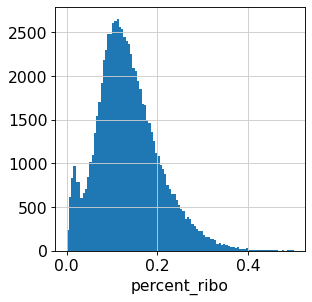

In [37]:
_ = plt.hist(adata.obs['percent_ribo'], bins=100)
plt.xlabel('percent_ribo')

In [38]:
hbb_genes = ['HBB']
adata.obs['percent_hbb'] = np.array(adata[:, 'HBB'].X.todense()).reshape(-1) / adata.obs['n_counts'].values


Text(0.5, 0, 'percent_hbb')

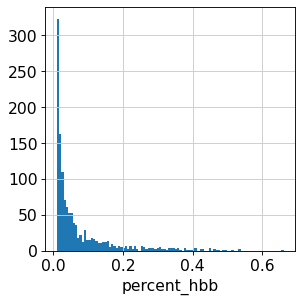

In [39]:
percent_hbb = adata.obs['percent_hbb']
_ = plt.hist(percent_hbb.loc[percent_hbb>.01], bins=100)
plt.xlabel('percent_hbb')

In [40]:
adata = adata[adata.obs['percent_hbb']<=.1, :]

In [41]:
sc.pp.filter_genes(adata, min_cells=10)

filtered out 831 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


## Define blacklist genes

In [42]:
mito_corr_genes = list(R_mito.index[R_mito>.1])

In [43]:
ebov_genes = [x for x in adata.var.index if 'EBOV' in x]

In [44]:
blacklist_genes = ribogenes + ['HBB'] + ebov_genes + mito_corr_genes

In [45]:
len(blacklist_genes), len(mito_corr_genes), len(ebov_genes), len(ribogenes)

(193, 92, 8, 92)

In [46]:
len(blacklist_genes), len(mito_corr_genes), len(ebov_genes), len(ribogenes)

(193, 92, 8, 92)

In [47]:
ebov_blacklist_fn = os.path.join(adir, '{project}.blacklist.EBOV.txt'.format(project=project_name))
open(ebov_blacklist_fn, 'w').write('\n'.join(ebov_genes))

ribo_blacklist_fn = os.path.join(adir, '{project}.blacklist.RIBO.txt'.format(project=project_name))
open(ribo_blacklist_fn, 'w').write('\n'.join(ribogenes))

mito_blacklist_fn = os.path.join(adir, '{project}.blacklist.MITO.txt'.format(project=project_name))
open(mito_blacklist_fn, 'w').write('\n'.join(mito_corr_genes))

combined_blacklist_fn = os.path.join(adir, '{project}.blacklist.COMBINED.txt'.format(project=project_name))
open(combined_blacklist_fn, 'w').write('\n'.join(blacklist_genes))

1632

In [48]:
adata.var['Combined_Blacklist'] = adata.var.index.isin(blacklist_genes)
adata.var['EBOV_Blacklist'] = adata.var.index.isin(ebov_genes)
adata.var['Mito_Blacklist'] = adata.var.index.isin(mito_corr_genes)
adata.var['Ribo_Blacklist'] = adata.var.index.isin(ribogenes)

In [6]:
results_prefilt = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh))
print(results_prefilt)

../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.h5ad


In [50]:
save_adata(adata, results_prefilt, gcs=gcs)

Only considering the two last: ['.1', '.h5ad'].
Only considering the two last: ['.1', '.h5ad'].


In [7]:
adata = read_adata(results_prefilt, gcs=gcs)

Only considering the two last: ['.1', '.h5ad'].
Only considering the two last: ['.1', '.h5ad'].


In [8]:
adata

AnnData object with n_obs × n_vars = 77878 × 18305 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist'
    uns: 'DPIc_colors'

In [10]:
adata.obs['sample_source'].unique().shape[0]

28

<a id="Filter_mdcks"></a>
## 3. Run full clustering + UMAP pipeline to identify and filter MDCKs

In [52]:
adata.raw = adata.copy()

In [53]:
adata = adata[:,~adata.var['Combined_Blacklist']]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=nhvgs)
adata.var['highly_variable'].value_counts()

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


False    15869
True      2244
Name: highly_variable, dtype: int64

In [54]:
sc.pp.scale(adata, max_value=10)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:08)


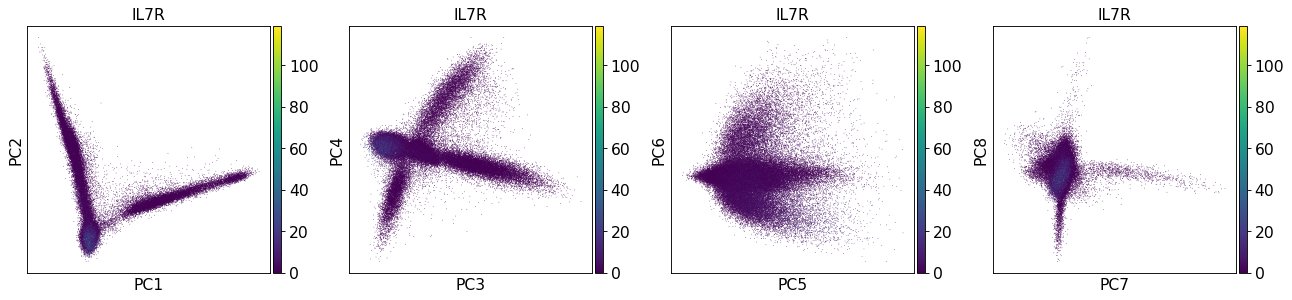

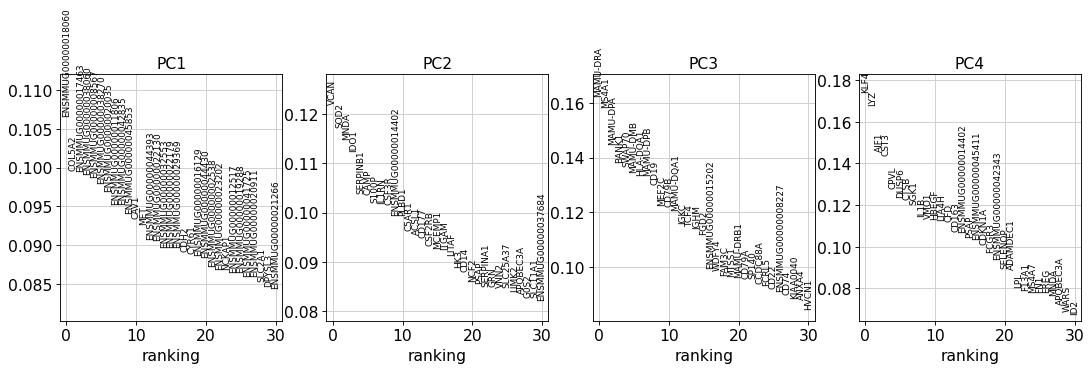

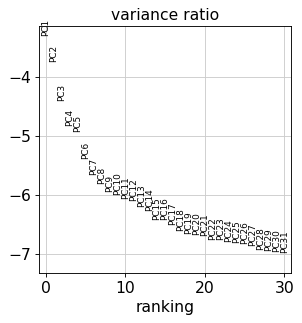

In [55]:
sc.tl.pca(adata, svd_solver='arpack', random_state=14, use_highly_variable=True)

sc.pl.pca(adata, components=['1,2', '3,4', '5,6', '7,8'], color=['IL7R'],
          ncols=4, use_raw=True)

sc.pl.pca_loadings(adata, components=[1,2,3,4])

sc.pl.pca_variance_ratio(adata, log=True)


In [56]:
sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.001), n_pcs=18, random_state=14)
    
sc.tl.umap(adata, min_dist=0.1, spread=2.0, random_state=14)

computing neighbors
    using 'X_pca' with n_pcs = 18


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:02)


In [57]:
adata

AnnData object with n_obs × n_vars = 77878 × 18113 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DPIc_colors', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

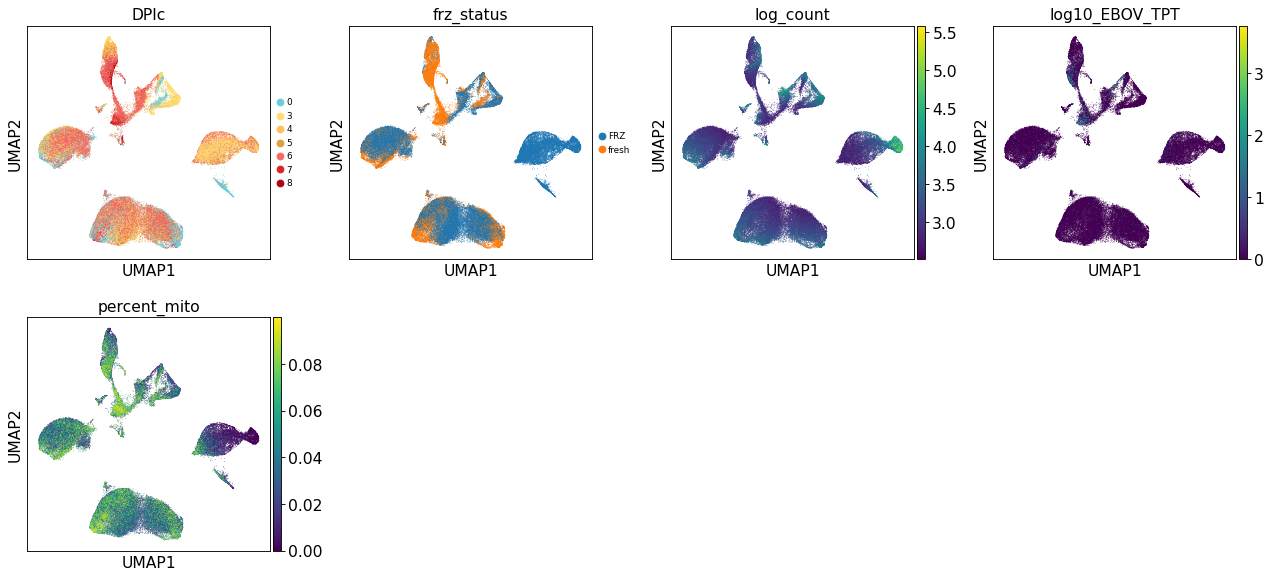

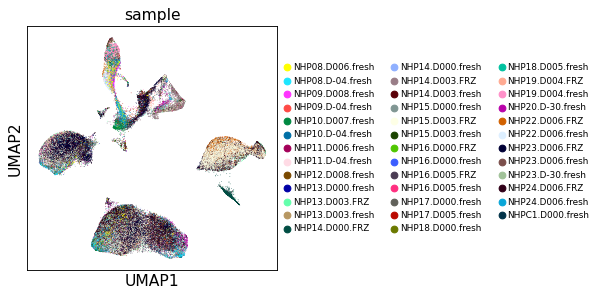

In [58]:
sc.pl.umap(adata, color=['DPIc', 'frz_status', 'log_count', 'log10_EBOV_TPT', 'percent_mito'],legend_fontsize=8)
sc.pl.umap(adata, color=['sample'], legend_fontsize=8)


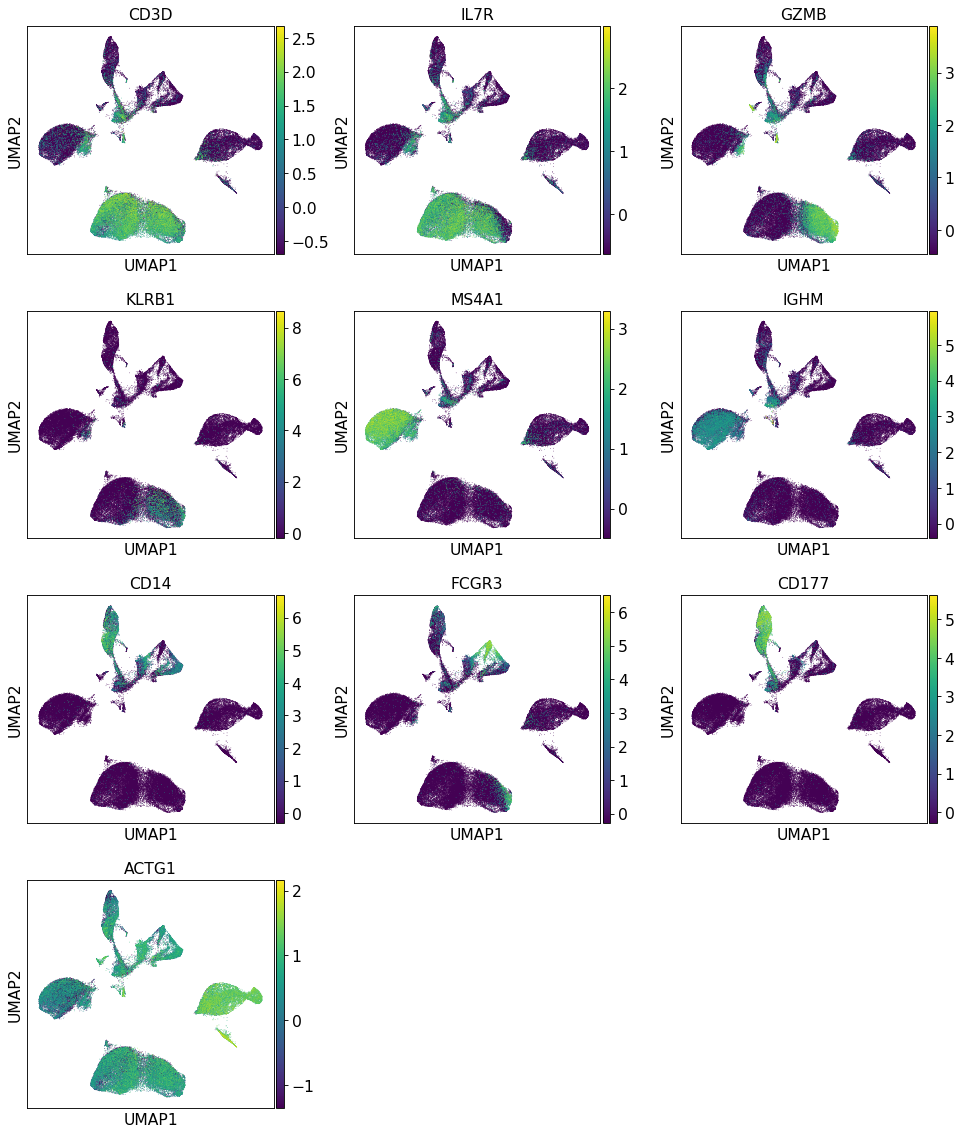

In [59]:
sc.pl.umap(adata, color=['CD3D', 'IL7R', 'GZMB', 'KLRB1', 'MS4A1', 'IGHM', 'CD14', 'FCGR3', 'CD177', 'ACTG1'],
           ncols=3, use_raw=False)

In [60]:
sc.tl.leiden(adata, random_state=14, resolution=1.)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:06:24)


In [61]:
adata.obs['leiden'].value_counts()

0     11292
1      9699
2      8200
3      7718
4      6868
5      6062
6      6019
7      4436
8      4198
9      3843
10     3398
11     2636
12     1287
13     1100
14      504
15      376
16      242
Name: leiden, dtype: int64

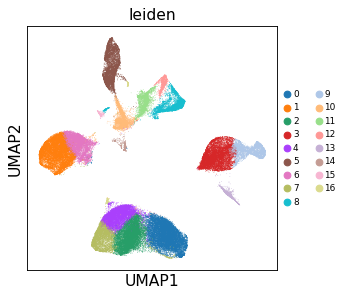

In [62]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=8)

In [63]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:58)


0         1        2                   3       4       5  \
0                GZMB     MS4A1    SYNE2                 VIM  GIMAP7  S100A9   
1                GNLY  MAMU-DRA     IL7R  ENSMMUG00000018060     CA6  S100A8   
2              GIMAP7     BANK1   GIMAP7               H2AFZ    CD3D    SOD2   
3                GZMH    SWAP70     CD3D  ENSMMUG00000022130    IL7R    SELL   
4                CD3D      CD19     TPT1  ENSMMUG00000017463    LEF1    CAMP   
5  ENSMMUG00000038528  MAMU-DPA     RGS1               ANXA2   ITGA6   IFIT1   
6            PPP1R12A     CD79B  ZFP36L2  ENSMMUG00000008567    TCF7   CD177   
7                 ID2  HLA-DQA1     CD69  ENSMMUG00000011806  PECAM1   CSF3R   
8              TGFBR3      IGHM    KCNA3  ENSMMUG00000020035   RFLNB   LITAF   
9                RGS9  MAMU-DPB    TRIB2  ENSMMUG00000038060  RPL10A    VNN2   

          6                   7                   8                   9  \
0     MS4A1  ENSMMUG00000028701                 LYZ                 VIM   
1      IGKC                IL7R                PSAP               H2AFZ   
2     BANK1                ETS1                MNDA  ENSMMUG00000022130   
3      IGHM              GIMAP7                CTSB  ENSMMUG00000018060   
4    SWAP70                TCF7  ENSMMUG00000014402              COL5A2   
5  MAMU-DRA                COX2                KLF4  ENSMMUG00000017463   
6      CD19              PECAM1                VCAN  ENSMMUG00000013136   
7     CD79B  ENSMMUG00000015270                AIF1             HSP90B1   
8  HLA-DQA1              RPL10A            SERPINB1               ANXA2   
9  MAMU-DPA                RPS2               PLBD1               ACTR3   

                   10                  11                  12  \
0              S100A9                 LYZ                 CFD   
1              S100A8  ENSMMUG00000014402               FCGR3   
2                PPBP                CTSB                PSAP   
3               IFI27              S100A8                CTSB   
4  ENSMMUG00000028701              S100A9               ITGB2   
5                COX2                MNDA               LTA4H   
6               PLAC8               IFI27                AIF1   
7                 MX1               PLAC8  ENSMMUG00000013289   
8                SOD2                PSAP              PECAM1   
9              RNF213            SERPINB1                MNDA   

                   13                  14      15                  16  
0                EMP1               MKI67    IRF8                PPBP  
1               ACTG1               STMN1   PLAC8              CAVIN2  
2            TRBV24-1                SMC4    GZMB                 PF4  
3             SLC20A1                ACTB     TXN               TUBB1  
4                 GLS               ACTG1    TCF4               RGS18  
5               CYR61  ENSMMUG00000003187   NGLY1  ENSMMUG00000038836  
6              ATP1A1                SMC2    CTSB               GNG11  
7  ENSMMUG00000018060              CORO1A  CCDC50                NRGN  
8               ANXA2              TUBA1B    MNDA                NEXN  
9                NQO1                RPS2    CTSC  ENSMMUG00000047819

In [64]:
mapping2 = {'0':'Tc/NK 1', '1':'B 1', '2':'Th 1', '3':'MDCK 1', '4':'Th 2', 
            '5':'Neut 1', '6':'B 2', '7':'Th 3', '8':'Mono/DC 1', '9':'MDCK 2',
            '10':'Multiplet', '11':'Mono/DC 2', '12':'Mono/DC 3',
            '13':'MDCK 3', '14':'Replicating 1', '15':'Mono/DC 4', '16':'Platelet 1'}
adata.obs['leiden_lab_orig'] = adata.obs['leiden'].replace(mapping2)
adata.obs['leiden_lab_orig_group'] = adata.obs['leiden_lab_orig'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab_orig' as categorical
... storing 'leiden_lab_orig_group' as categorical


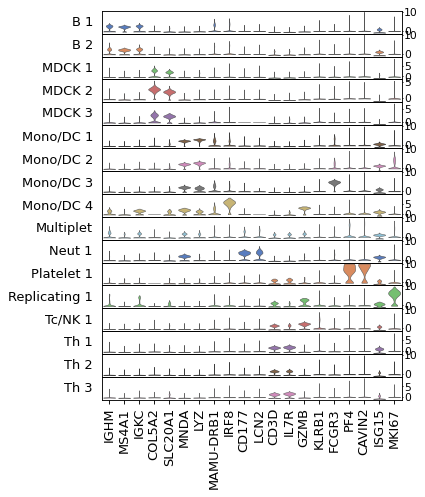

In [65]:
marker_genes = ['IGHM', 'MS4A1', 'IGKC',
                'COL5A2', 'SLC20A1', 
                'MNDA', 'LYZ',
                'MAMU-DRB1', 'IRF8',
                'CD177', 'LCN2',
                'CD3D', 'IL7R', 'GZMB', 'KLRB1',  'FCGR3',
                'PF4', 'CAVIN2', 'ISG15', 'MKI67']

gs = sc.pl.stacked_violin(adata,var_names=marker_genes, groupby='leiden_lab_orig', use_raw=False)

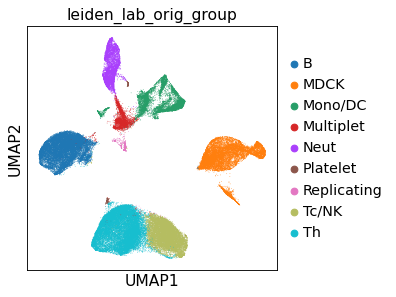

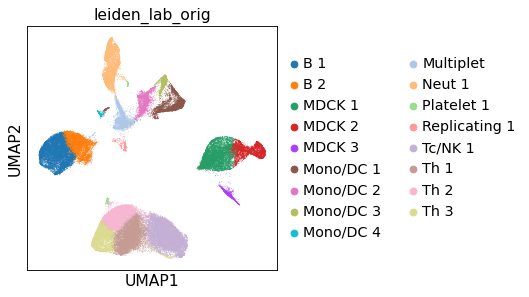

In [66]:
sc.pl.umap(adata, color=['leiden_lab_orig_group'])
sc.pl.umap(adata, color=['leiden_lab_orig'])

In [22]:
adata

AnnData object with n_obs × n_vars = 77878 × 18113 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'Is_NovaNext'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DPIc_colors', 'frz_status_colors', 'leiden', 'leiden_colors', 'l

In [12]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.Blacklist.TPT.{log}.HVGs_{nhvgs}.scale.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
results_file

'../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.Blacklist.TPT.log.HVGs_None.scale.h5ad'

In [68]:
save_adata(adata, results_file, gcs=gcs)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].


In [13]:
adata = read_adata(results_file, gcs=gcs)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].


In [93]:
## Save a summary file containing information about all of the arrays including number of cells passing basic filters
Z = adata.obs[['animal', 'DPI', 'frz_status', 'array_num', 'dash_status', 'batch','sample_source', 'n_counts']]

cellcount = Z.groupby(['animal', 'DPI', 'frz_status', 'array_num', 'dash_status', 'batch']).count().dropna().rename(columns={'sample_source':'num_cells', 'n_counts':'median_umis_percell'})
medianumi =  Z.groupby(['animal', 'DPI', 'frz_status', 'array_num', 'dash_status', 'batch'])['n_counts'].median().dropna()
cellcount['median_umis_percell'] =medianumi.loc[cellcount.index]
cellcount = cellcount.reset_index()

cellcount['MDCK_Spike_In'] = cellcount['batch'].apply(lambda x: 'MDCK' in x)
cellcount['MDCK_Spike_In'] = cellcount['batch'].apply(lambda x: 'MDCK' in x)
cellcount.drop('batch', axis=1, inplace=True)
outfn = os.path.join(results_dir, 'Array_Summary.tsv')
cellcount.to_csv(outfn, sep='\t', index=False)
cellcount.head()

animal  DPI frz_status array_num dash_status  num_cells  \
0  NHP08   -4      fresh        a1        DASH      948.0   
1  NHP08    6      fresh        a1     DASH2x3      713.0   
2  NHP09   -4      fresh        a1        DASH      338.0   
3  NHP09    8      fresh        a1     DASH2x3      946.0   
4  NHP10   -4      fresh        a1        DASH      789.0   

   median_umis_percell MDCK_Spike_In  
0               1269.0         False  
1                584.0         False  
2                939.0         False  
3                743.0         False  
4               1350.0         False

<a id="Filter_mdcks2"></a>
## Grab MDCKs to filter out

In [69]:
adata_raw = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)

In [70]:
adata_raw

AnnData object with n_obs × n_vars = 77878 × 18305 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist'
    uns: 'DPIc_colors', 'pca', 'neighbors', 'frz_status_colors', 'sample_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'leiden_lab_orig_group

In [71]:
mdck_ind = adata_raw.obs['leiden_lab_orig_group']=='MDCK'
mdck_ind.value_counts()

False    65217
True     12661
Name: leiden_lab_orig_group, dtype: int64

In [72]:
adata_mdck = adata_raw[mdck_ind, :]
adata_nomdck = adata_raw[~mdck_ind, :]

In [73]:
results_nomdck = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.NoMDCK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
results_mdck = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.OnlyMDCK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))

print(results_nomdck)

print(results_mdck)



../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.NoMDCK.h5ad
../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.OnlyMDCK.h5ad


In [74]:
save_adata(adata_mdck, results_mdck, gcs=gcs)
save_adata(adata_nomdck, results_nomdck, gcs=gcs)

Only considering the two last: ['.OnlyMDCK', '.h5ad'].
Only considering the two last: ['.OnlyMDCK', '.h5ad'].
Only considering the two last: ['.NoMDCK', '.h5ad'].
Only considering the two last: ['.NoMDCK', '.h5ad'].


## Repeat clustering without MDCKs or multiplets

In [75]:
adata = adata_nomdck[~adata_nomdck.obs['leiden_lab_orig_group'].isin(['Multiplet']), :]

In [76]:
X = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index)
X = X.div(X.sum(axis=1), axis=0)*10000
X = np.log(X+1)

In [77]:
R_TOP2A = X.corrwith(X['TOP2A'], method='pearson').sort_values(ascending=False)

In [78]:
top2a_corr_genes = list(R_TOP2A.index[R_TOP2A>.1])
len(top2a_corr_genes)

93

In [79]:
top2a_corr_genes

['TOP2A',
 'MKI67',
 'DLGAP5',
 'BIRC5',
 'ASPM',
 'SPAG5',
 'KIF4A',
 'KIF11',
 'NUSAP1',
 'NCAPG',
 'CEP55',
 'HMMR',
 'BUB1',
 'CCNB2',
 'KIFC1',
 'ANLN',
 'FOXM1',
 'RRM2',
 'SHCBP1',
 'CCNA2',
 'NUF2',
 'STMN1',
 'DEPDC1',
 'NEK2',
 'TK1',
 'TPX2',
 'CENPE',
 'CDC20',
 'CLSPN',
 'CDK1',
 'ENSMMUG00000021023',
 'AURKA',
 'HIST1H1B',
 'RAD51',
 'SMC2',
 'AURKB',
 'DIAPH3',
 'CDCA2',
 'KIF15',
 'MELK',
 'TYMS',
 'CDKN3',
 'CIT',
 'PRC1',
 'KIF2C',
 'GTSE1',
 'KIF14',
 'ESCO2',
 'ZWINT',
 'KIF23',
 'ARHGAP11A',
 'BRCA2',
 'SGO1',
 'PKMYT1',
 'NCAPD2',
 'E2F8',
 'CCNB1',
 'CENPF',
 'CCNF',
 'ENSMMUG00000048107',
 'PCLAF',
 'PRR11',
 'RAD51AP1',
 'CENPW',
 'KNTC1',
 'KIF20A',
 'KNL1',
 'RAD54L',
 'CHAF1A',
 'BUB1B',
 'ZBED2',
 'HIST1H1D',
 'PARPBP',
 'TUBB',
 'ENSMMUG00000003187',
 'SMC4',
 'SKA3',
 'MYBL2',
 'MPO',
 'SPDL1',
 'HJURP',
 'MCM4',
 'KIF22',
 'TUBA1C',
 'NCAPH',
 'PTTG1',
 'DEPDC1B',
 'WDHD1',
 'CDC25C',
 'MCM3',
 'UHRF1',
 'CDC6',
 'CENPM']

In [80]:
cc_blacklist_fn = os.path.join(adir, '{project}.blacklist.CellCycle.txt'.format(project=project_name))
open(cc_blacklist_fn, 'w').write('\n'.join(top2a_corr_genes))

595

In [81]:
adata.var['CC_Blacklist'] = adata.var.index.isin(top2a_corr_genes)

Trying to set attribute `.var` of view, copying.


In [82]:
adata.var['CC_Blacklist'].sum()

93

In [83]:
sc.pp.filter_genes(adata, min_cells=10)

filtered out 1168 genes that are detectedin less than 10 cells


In [84]:
results_nomdck = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.NoMDCKBOD.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))

In [85]:
save_adata(adata, results_nomdck)

Only considering the two last: ['.NoMDCKBOD', '.h5ad'].
Only considering the two last: ['.NoMDCKBOD', '.h5ad'].


In [86]:
adata.raw = adata.copy()

In [87]:
adata = adata[:,~(adata.var['Combined_Blacklist'] | adata.var['CC_Blacklist'])]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=nhvgs)
adata.var['highly_variable'].value_counts()

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


False    14570
True      2283
Name: highly_variable, dtype: int64

In [88]:
sc.pp.scale(adata, max_value=10)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:09)


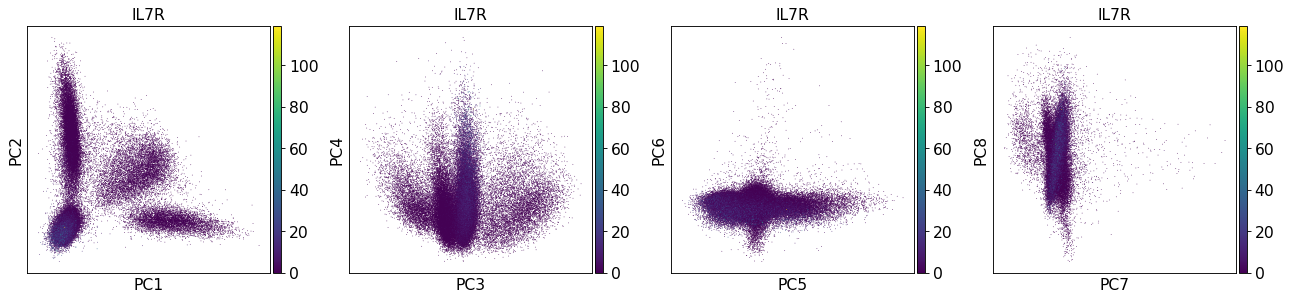

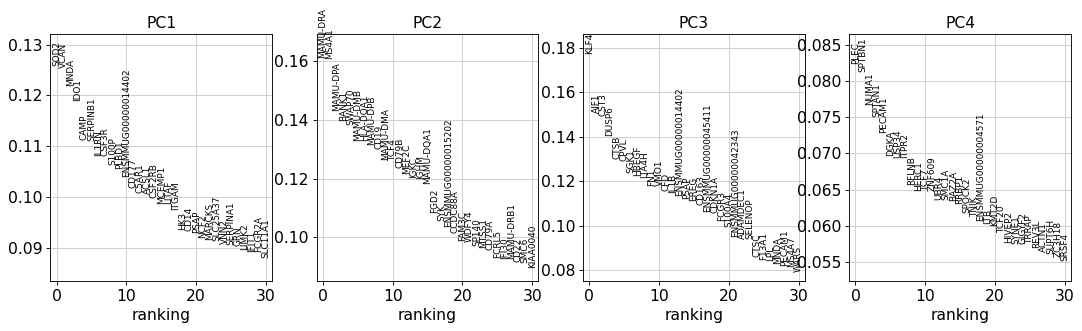

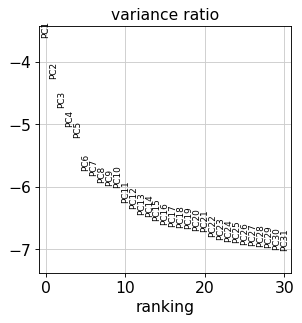

In [89]:
sc.tl.pca(adata, svd_solver='arpack', random_state=14, use_highly_variable=True)

sc.pl.pca(adata, components=['1,2', '3,4', '5,6', '7,8'], color=['IL7R'],
          ncols=4, use_raw=True)

sc.pl.pca_loadings(adata, components=[1,2,3,4])

sc.pl.pca_variance_ratio(adata, log=True)


In [90]:
Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = 'frz_status', theta=1, random_state=0)
adata.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


In [91]:
sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.001), n_pcs=16, random_state=17, use_rep='X_harmony')
    
sc.tl.umap(adata, min_dist=0.1, spread=2.0, random_state=14)

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:23)


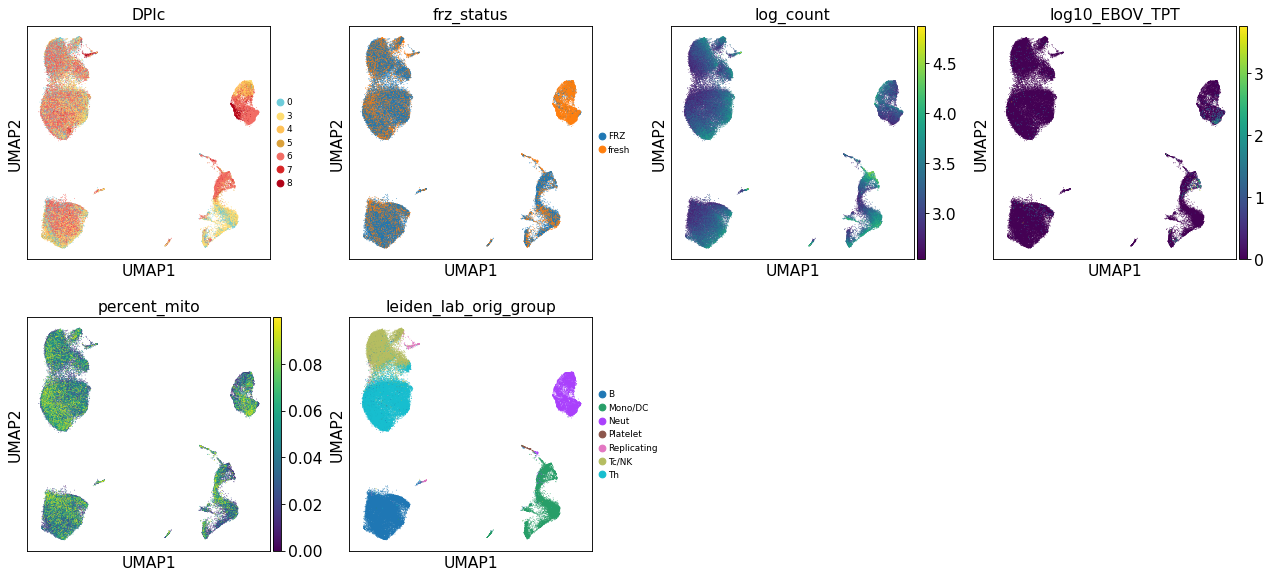

In [92]:
sc.pl.umap(adata, color=['DPIc', 'frz_status', 'log_count', 'log10_EBOV_TPT', 'percent_mito', 'leiden_lab_orig_group'],legend_fontsize=8)

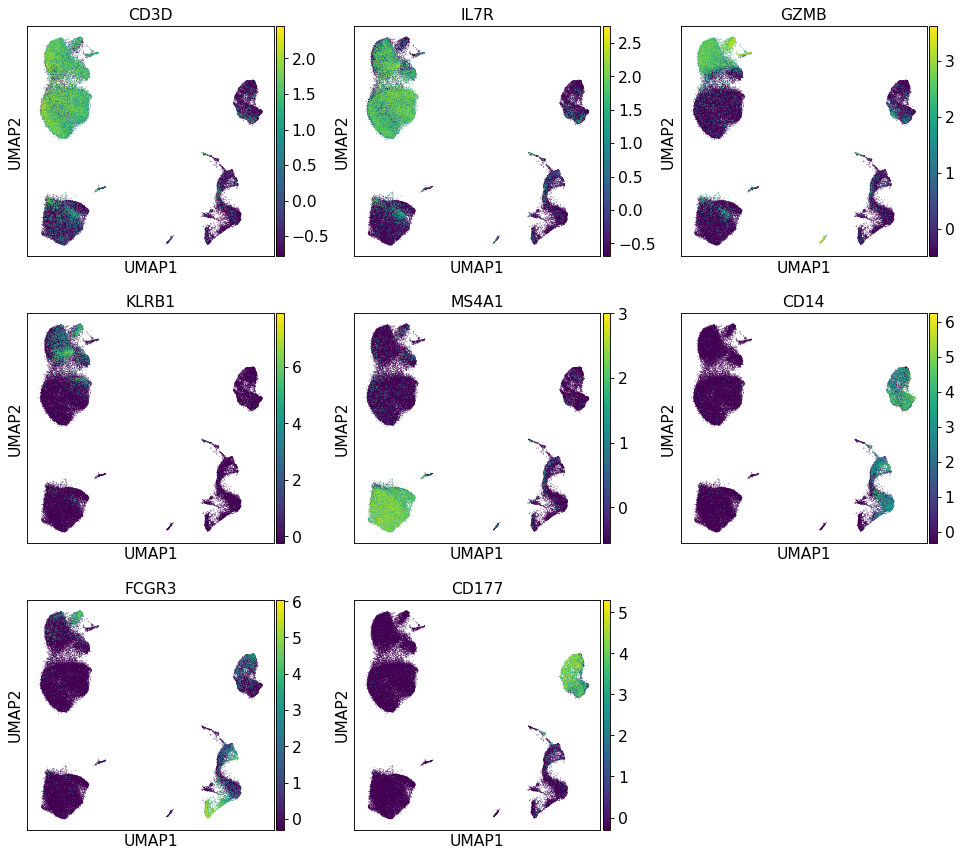

In [93]:
sc.pl.umap(adata, color=['CD3D', 'IL7R', 'GZMB', 'KLRB1', 'MS4A1', 'CD14', 'FCGR3', 'CD177'], ncols=3, use_raw=False)

In [94]:
sc.tl.leiden(adata, resolution=1.8, random_state=14)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:04:09)


In [95]:
adata.obs['leiden'].value_counts()

0     8713
1     6012
2     5297
3     5094
4     5046
5     4507
6     4456
7     4172
8     3862
9     3348
10    2737
11    2626
12    1998
13    1238
14    1191
15     683
16     308
17     291
18     240
Name: leiden, dtype: int64

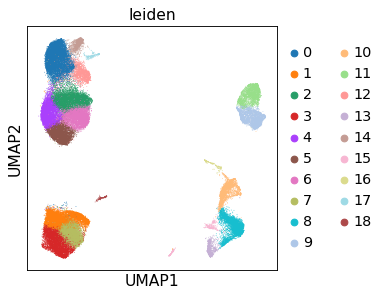

In [96]:
sc.pl.umap(adata, color='leiden')

In [97]:
adata

AnnData object with n_obs × n_vars = 61819 × 16853 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DPIc_colors', 'pca', 'neighbors', 'frz_status_colors', 'sample_

In [98]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20).T

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:34)


0                   1                   2        3  \
0                 GZMB                GNLY                GZMH   GIMAP7   
1                MS4A1                IGHM                IGKC    CD79B   
2                 IL7R               SYNE2             ZFP36L2    ITGB1   
3                MS4A1            MAMU-DRA              GPR183     CD19   
4                  CA6              GIMAP7                LEF1    ITGA6   
5                  CA6              GIMAP7               ITGA6   PECAM1   
6                 IL7R               SYNE2               TRIB2   GIMAP7   
7                MS4A1               BANK1              SWAP70    CD79B   
8                  LYZ                PSAP                 VIM     MNDA   
9               S100A9              S100A8                SOD2     LCN2   
10                 LYZ  ENSMMUG00000014402                CTSB   S100A8   
11               IFIT2              S100A9                SOD2     SELL   
12  ENSMMUG00000038528                GNLY  ENSMMUG00000042057     CD3D   
13                 CFD               FCGR3                PSAP    LTA4H   
14                GZMB                GNLY                GZMH    FCGR3   
15                 TXN                IRF8             CCDC88A     MNDA   
16                PPBP                 PF4              CAVIN2    TUBB1   
17               MKI67               ACTG1                GZMB    STMN1   
18  ENSMMUG00000038560  ENSMMUG00000002764                MZB1  HSP90B1   

           4                   5                   6         7  \
0   PPP1R12A                 ID2              TGFBR3      CD3D   
1     SWAP70               BANK1                CD19  MAMU-DRA   
2       RGS1              GIMAP7                CD69      CD3D   
3      BANK1            MAMU-DPA            HLA-DQA1    SWAP70   
4       TCF7               RFLNB                CD3D      IL7R   
5      RFLNB                LEF1              RPL10A      TCF7   
6      KCNA3                TPT1                CD3D   ZFP36L2   
7       TCF4            MAMU-DRA                IGHM      IGKC   
8       CTSB  ENSMMUG00000014402                VCAN     DUSP6   
9       CAMP                VNN2               CSF3R    MCEMP1   
10    S100A9                MNDA               IFI27     PLAC8   
11     IFIT1              S100A8               CD177     LITAF   
12     SCML4                TCF7               ITGAX     IL2RB   
13      CTSB               ITGB2                AIF1     MS4A7   
14      HOPX                GZMA               IL2RB     ZAP70   
15     PLAC8            MAMU-DPA            MAMU-DRA  MAMU-DPB   
16     GNG11               RGS18  ENSMMUG00000038836      NRGN   
17      ACTB                SMC2               HMGB1      ENO1   
18      IRF4               PDIA4                SUB1      IGKC   

                     8                   9                  10         11  \
0   ENSMMUG00000038528                RGS9               SYTL2       CD69   
1                 TCF4            MAMU-DMB                SMC6   HLA-DQA1   
2                KCNA3               DPEP2              SPOCK2       TPT1   
3                MEF2C            MAMU-DPB  ENSMMUG00000015202  MAMU-DQA1   
4               PECAM1              RPL10A               BACH2      TRIB2   
5                RPS15               RPL22                CD3D       IL7R   
6                 LEF1               RPL13               MBNL1       ETS1   
7                 CD19                SMC6            KIAA0040   HLA-DQA1   
8                 KLF4                AIF1            SERPINB1      PLBD1   
9                 VCAN               CD177                CTSD       SELL   
10            SERPINB1                PSAP                CYBB       VCAN   
11            SLC25A37                CAMP               IFIT3      ISG15   
12                 LCK               PRKCH                ETS1     GIMAP7   
13  ENSMMUG00000013289              PECAM1                 LYN       MNDA   
14               SYTL2                RGS9  

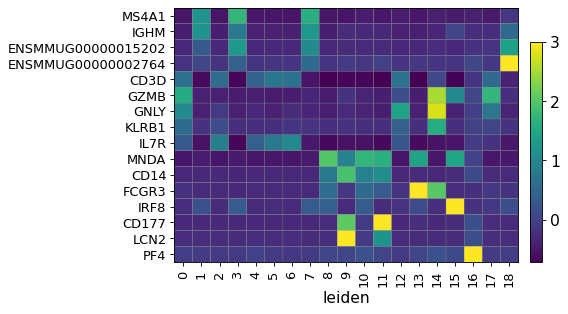

GridSpec(2, 3, height_ratios=[0, 3.2], width_ratios=[5.7, 0, 0.2])

In [99]:
sc.pl.matrixplot(adata, 
                 var_names=['MS4A1', 'IGHM', 'ENSMMUG00000015202', 'ENSMMUG00000002764',
                            'CD3D', 'GZMB', 'GNLY','KLRB1', 'IL7R',
                            'MNDA', 'CD14', 'FCGR3', 'IRF8',
                            'CD177', 'LCN2', 'PF4'],
                 groupby='leiden', swap_axes=True, use_raw=False, vmax=3)

In [100]:
mapping1 = {'0':'Tc 1', '1':'B 1', '2':'Th 1','3':'B 2', '4':'Th 2', '5':'Th 3', '6':'Th 4',
            '7':'B 3', '8':'Mono/DC 1', '9':'Neut 1', '10':'Mono/DC 2', '11':'Neut 2', '12':'Tc 2',
            '13':'Mono/DC 3', '14':'NK 1', '15':'Mono/DC 4', '16':'Platelet','17':'Tc 3',
             '18':'Plasmablast'}
adata.obs['leiden_lab_2'] = adata.obs['leiden'].replace(mapping1)

adata.obs['leiden_lab_group_2'] = adata.obs['leiden_lab_2'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab_2' as categorical
... storing 'leiden_lab_group_2' as categorical


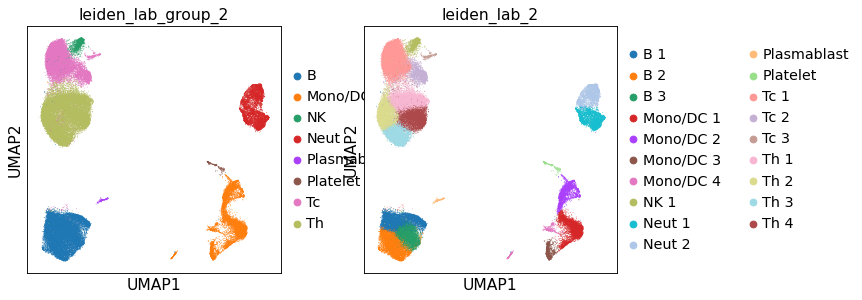

In [101]:
sc.pl.umap(adata, color=[ 'leiden_lab_group_2', 'leiden_lab_2'])

In [102]:
#### These will be filled in in the upcoming subclustering steps
adata.obs['SubclusteringGroup'] = np.nan
adata.obs['Subclustering'] = np.nan
adata.obs['Doublet'] = False

In [103]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
results_file

'../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.h5ad'

In [104]:
save_adata(adata, results_file, gcs=gcs)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].


In [105]:
adata = read_adata(results_file, gcs=gcs)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].


## Run subclustering

In [6]:
base_nbcommand = '''jupyter nbconvert --ExecutePreprocessor.allow_errors=True --ExecutePreprocessor.timeout=-1 --ExecutePreprocessor.timeout=-1 \
--FilesWriter.build_directory=../../../../results --execute %s'''


In [7]:
! {base_nbcommand % './Subclustering/Subcluster.Myeloid.ipynb'}
! {base_nbcommand % './Subclustering/Subcluster.B.ipynb'}
! {base_nbcommand % './Subclustering/Subcluster.TNK.ipynb'}

[NbConvertApp] Converting notebook ./Subclustering/Subcluster.Myeloid.ipynb to html
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 4654092 bytes to ../../../../results/Subcluster.Myeloid.html
[NbConvertApp] Converting notebook ./Subclustering/Subcluster.B.ipynb to html
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 5119648 bytes to ../../../../results/Subcluster.B.html
[NbConvertApp] Converting notebook ./Subclustering/Subcluster.TNK.ipynb to html
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 6544846 bytes to ../../../../results/Subcluster.TNK.html


## Repeat analysis after sub-clustering

In [6]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file)

../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterMBTNK.h5ad


In [7]:
adata = read_adata(results_file, gcs=gcs)

Only considering the two last: ['.SubclusterMBTNK', '.h5ad'].
Only considering the two last: ['.SubclusterMBTNK', '.h5ad'].


In [8]:
pd.crosstab([adata.obs['leiden_lab_group_2'], adata.obs['Doublet']], adata.obs['SubclusteringGroup'])

SubclusteringGroup          B_Memory  B_Memory_SELL+  B_Naive  Mono   NK  \
leiden_lab_group_2 Doublet                                                 
B                  False       10908             640     1936     0    0   
                   True            0               0        0     0    0   
Mono/DC            False           0               0        0  6958    0   
                   True            0               0        0     0    0   
NK                 False           0               0        0     0  959   
                   True            0               0        0     0    0   
Neut               False           0               0        0    12    0   
                   True            0               0        0     0    0   
Plasmablast        False          19               1        1     0    0   
                   True            0               0        0     0    0   
Platelet           False           0               0        0     6    0   
                   True            0               0        0     0    0   
Tc                 False           0               0        0     0  278   
                   True            0               0        0     0    0   
Th                 False           0               0        0     0    7   
                   True            0               0        0     0    0   

SubclusteringGroup          Neut  Plasmablast    Tc  Tc_GZMAhi_MKI67hi  \
leiden_lab_group_2 Doublet                                               
B                  False       0           90     0                  0   
                   True        0            0     0                  0   
Mono/DC            False      47            0     0                  0   
                   True        0            0     0                  0   
NK                 False       0            0   114                  5   
                   True        0            0     0                  0   
Neut               False    5756            0     0                  0   
                   True        0            0     0                  0   
Plasmablast        False       0          176     0                  0   
                   True        0            0     0                  0   
Platelet           False       2            0     0                  0   
                   True        0            0     0                  0   
Tc                 False       0            0  6021                273   
                   True        0            0     0                  0   
Th                 False       0            0   214                 32   
                   True        0            0     0                  0   

SubclusteringGroup          Tc_GZMKhi  Tc_ITGAXhi  Th_ITGB1hi_SELLlo  \
leiden_lab_group_2 Doublet                                             
B                  False            0           0                  0   
                   True             0           0                  0   
Mono/DC            False            0           0                  0   
                   True             0           0                  0   
NK                 False            4          10                  0   
                   True             0           0                  0   
Neut               False            0           0                  0   
                   True             0           0                  0   
Plasmablast        False            0           0                  0   
                   True             0           0                  0   
Platelet           False            0           0                  0   
                   True             0           0                  0   
Tc                 False         1848        1442                 39   
                   True             0           0                  0   
Th                 False          170         149               1766   
                   True             0           0                  0   

S

In [9]:
adata = adata[adata.obs['SubclusteringGroup']!='nan',:]

In [10]:
adata = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)


In [11]:
adata.raw = adata.copy()

In [12]:
tokeep = (~adata.var['Combined_Blacklist'])

In [13]:
adata = adata[:, tokeep]

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=nhvgs)
adata.var['highly_variable'].value_counts()

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


False    14576
True      2370
Name: highly_variable, dtype: int64

In [15]:
sc.pp.scale(adata, max_value=10)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:08)


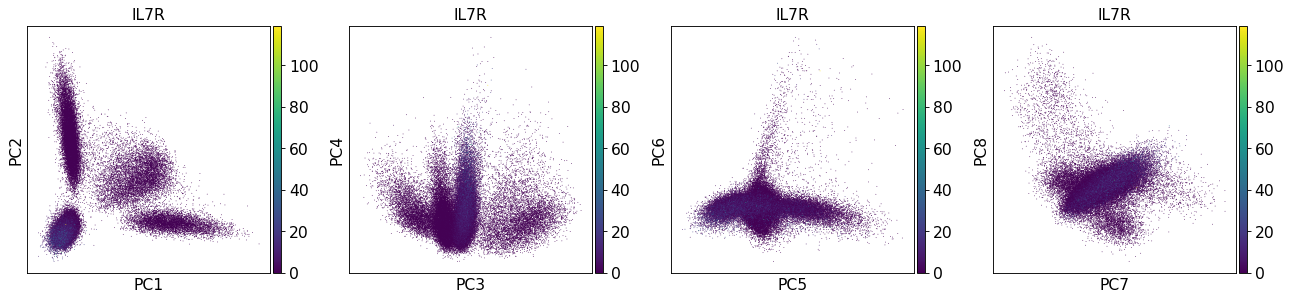

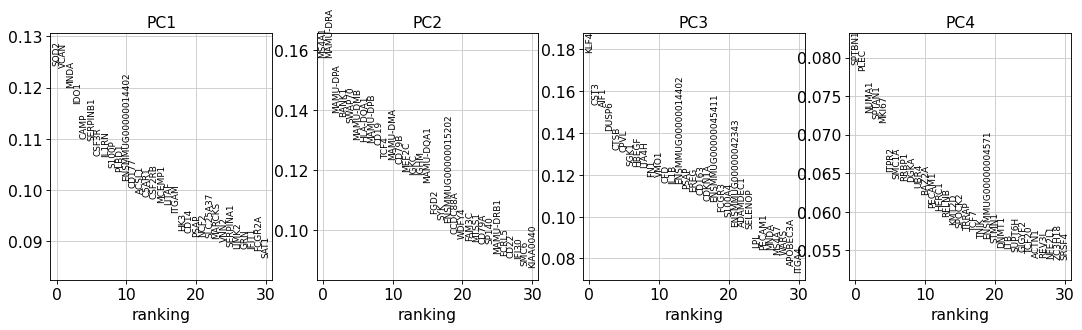

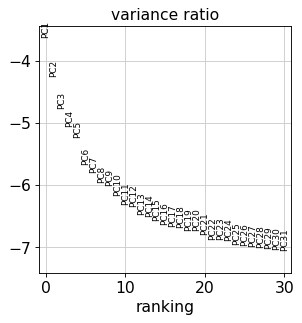

In [16]:
sc.tl.pca(adata, svd_solver='arpack', random_state=14, use_highly_variable=True)

sc.pl.pca(adata, components=['1,2', '3,4', '5,6', '7,8'], color=['IL7R'],
          ncols=4, use_raw=True)

sc.pl.pca_loadings(adata, components=[1,2,3,4])

sc.pl.pca_variance_ratio(adata, log=True)


In [17]:
Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = 'frz_status', theta=.3, random_state=0)
adata.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [18]:
sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.001), n_pcs=16, random_state=17, use_rep='X_harmony')
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=14)

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:04)


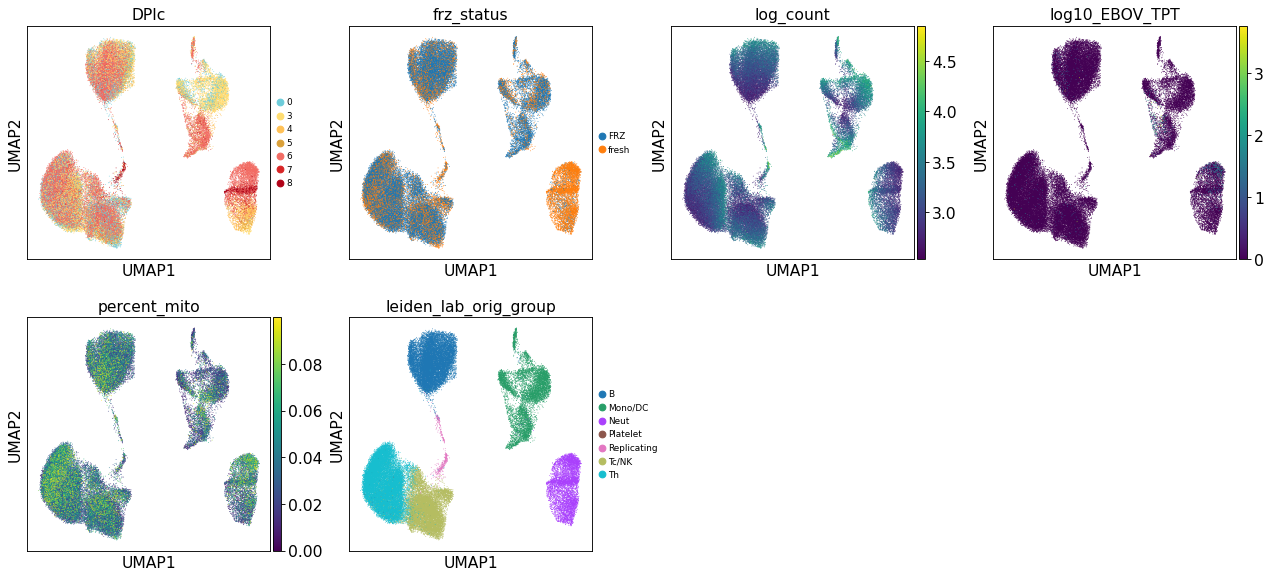

In [19]:
sc.pl.umap(adata, color=['DPIc', 'frz_status', 'log_count', 'log10_EBOV_TPT', 'percent_mito', 'leiden_lab_orig_group'],legend_fontsize=8)

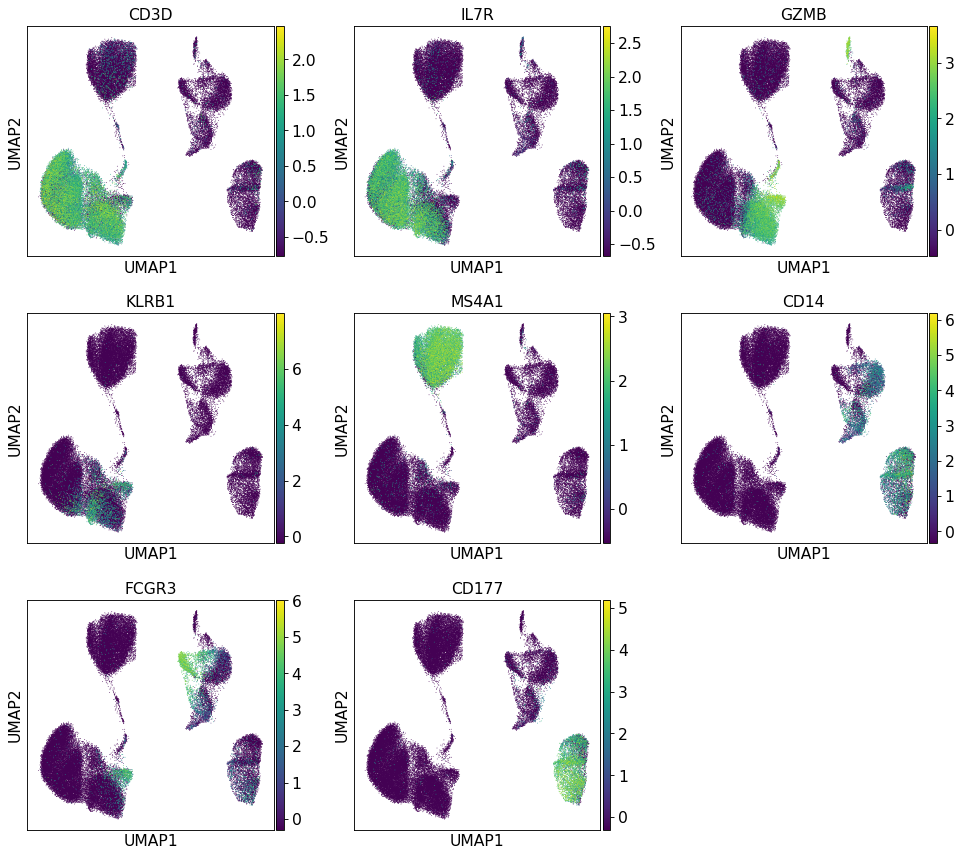

In [20]:
sc.pl.umap(adata, color=['CD3D', 'IL7R', 'GZMB', 'KLRB1', 'MS4A1', 'CD14', 'FCGR3', 'CD177'], ncols=3, use_raw=False)

In [21]:
adata.obs['SubclusteringGroup'].value_counts()

B_Memory               10927
Th_ITGB1mid_SELLmid     9136
Th_ITGB1lo_SELLhi       7233
Mono                    6976
Tc                      6349
Neut                    5805
Tc_GZMKhi               2022
B_Naive                 1937
Th_ITGB1hi_SELLlo       1805
Tc_ITGAXhi              1601
NK                      1244
B_Memory_SELL+           641
cDC                      345
pDC                      332
Tc_GZMAhi_MKI67hi        310
Plasmablast              266
Name: SubclusteringGroup, dtype: int64

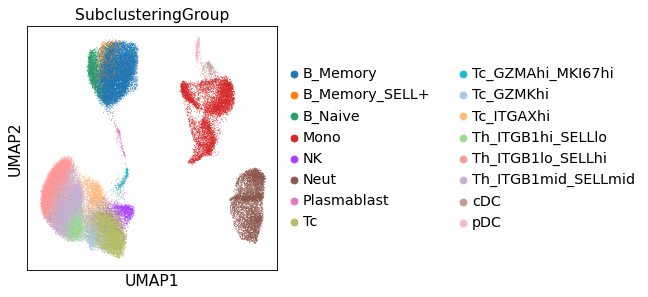

In [22]:
sc.pl.umap(adata, color='SubclusteringGroup')

In [23]:
adata.obs['Subclustering_reduced'] = adata.obs['SubclusteringGroup'].apply(lambda x: x.split('_')[0])

In [24]:
adata.uns['Subclustering_reduced_colors'] = palettable.tableau.Tableau_10.hex_colors

... storing 'Subclustering_reduced' as categorical


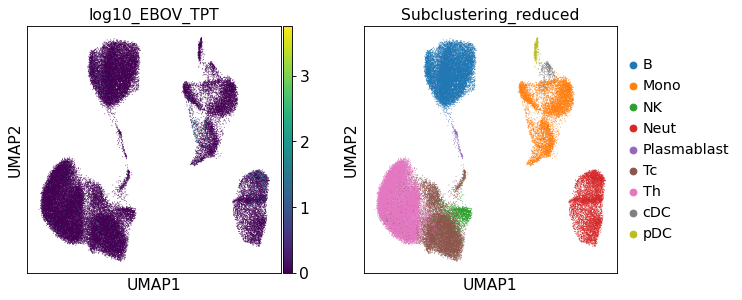

In [25]:
sc.pl.umap(adata, color=['log10_EBOV_TPT', 'Subclustering_reduced'])

In [26]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
ebov_cmap = LinearSegmentedColormap.from_list(name='ebov_cmap', colors=palettable.colorbrewer.sequential.OrRd_9.mpl_colors[1:])

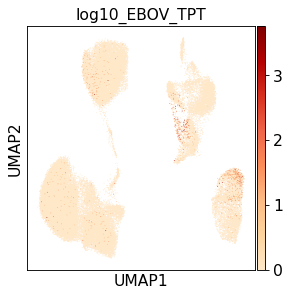

In [27]:
sc.pl.umap(adata, color='log10_EBOV_TPT', color_map=ebov_cmap, sort_order=True)

In [7]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))


In [29]:
save_adata(adata, results_file, gcs=gcs)

Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


In [8]:
adata = read_adata(results_file, gcs=gcs)

Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


In [11]:
adata.obs['sample']

batch  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
...                                                                                               ...   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   

                                                    DPI DPIc    Period  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0    0  Baseline   
...                                                 ...  ...       ...   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3    3     Early   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3    3     Early   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3    3     Early   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3    3     Early   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3    3     Early   

                                                                    full_sample_id  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
...                                                                            ...   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   

                                                   frz_status sample_source  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
...                                                       ...           ...   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...      fresh    NHP15.D003   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...      fresh    NHP15.D003   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...      fresh    NHP15.D003   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...      fresh    NHP15.D003   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_M

## Run infected cell calling

In [13]:
nbcommand = '''jupyter nbconvert --ExecutePreprocessor.allow_errors=True --ExecutePreprocessor.timeout=-1 --ExecutePreprocessor.timeout=-1 \
--FilesWriter.build_directory=../../../../results --execute Detect_Infected_Cells_InVivo.ipynb'''
print(nbcommand)
!{nbcommand}

jupyter nbconvert --ExecutePreprocessor.allow_errors=True --ExecutePreprocessor.timeout=-1 --ExecutePreprocessor.timeout=-1 --FilesWriter.build_directory=../../../../results --execute Detect_Infected_Cells_InVivo.ipynb
[NbConvertApp] Converting notebook Detect_Infected_Cells_InVivo.ipynb to html
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 2829559 bytes to ../../../../results/Detect_Infected_Cells_InVivo.html


In [6]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file)

../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad


In [7]:
adata = read_adata(results_file, gcs=gcs)

Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].


## Make UMAPs

In [8]:
umapdata = adata.obs.copy()
umapdata['UMAP_1'] = adata.obsm['X_umap'][:,0]
umapdata['UMAP_2'] = adata.obsm['X_umap'][:,1]

umapdata['Subclustering_clean'] = umapdata['Subclustering_reduced'].replace({'Tc': 'T CD8+', 'Th': 'T CD4+', 'Neut':'Neutrophil', 'Mono':'Monocyte'})

colors = np.array([x for x in palettable.tableau.TrafficLight_9.hex_colors])
#sns.palplot(colors)
#sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(range(9), colors[[8,8,5, 7, 4, 1, 6,3,0]]))
dpimap[0] = palettable.tableau.TableauMedium_10.hex_colors[-1]

umapdata['dpi_color'] = umapdata['DPIc'].apply(lambda x: dpimap[int(x)])


In [9]:
pd.crosstab(umapdata['Subclustering_clean'], umapdata['Period'])

Period               Baseline  Early  Late   Mid
Subclustering_clean                             
B                        1951   2848  6018  2688
Monocyte                  736   3603  1630  1007
NK                        577    123   397   147
Neutrophil                 10    371  3772  1652
Plasmablast                42     53   148    23
T CD4+                   2855   4613  7323  3383
T CD8+                   1933   2163  3691  2495
cDC                        73    189    60    23
pDC                        21     78   186    47

array(['B', 'Monocyte', 'NK', 'Neutrophil', 'Plasmablast', 'T CD4+',
       'T CD8+', 'cDC', 'pDC'], dtype=object)

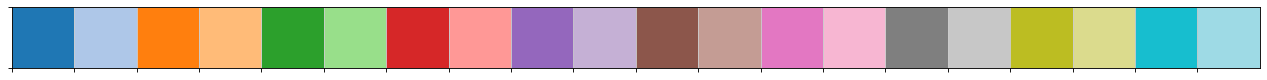

In [14]:
clustering = np.unique(umapdata['Subclustering_clean'])
c = palettable.tableau.Tableau_20.hex_colors
celltype_colors = {'B':c[0], 'Plasmablast':c[19], 'T CD8+':c[3], 'T CD4+':c[2], 'NK':c[6], 'Monocyte':c[4], 'cDC':c[5], 'pDC':c[16], 'Neutrophil':c[8], 'Platelet':c[9]}
umapdata['cluster_color'] = umapdata['Subclustering_clean'].apply(lambda x: celltype_colors[x])
sns.palplot(c)
clustering

In [15]:
umapdata['log10_EBOV_TPT_Clean'] = umapdata['log10_EBOV_TPT'].copy()
umapdata.loc[umapdata['Ebola_Positive']==False, 'log10_EBOV_TPT_Clean']=0

In [16]:
umapdata['frz_status_color'] = umapdata['frz_status'].replace({'FRZ':c[0], 'fresh':c[2]})

In [17]:
dash_status = ['std','mixed', 'DASH',  'DASH2x3']
dash_status_clean = ['No DASH','mixed', 'DASH',  'DASHx2']
dash_status_rename = dict(zip(dash_status, dash_status_clean))
umapdata['dash_status_clean'] = umapdata['dash_status'].replace(dash_status_rename)

dash_status_color = [c[0],c[4], c[2],  c[6]]
dash_status_map = dict(zip(dash_status_clean, dash_status_color))
umapdata['dash_status_color'] = umapdata['dash_status_clean'].replace(dash_status_map)

In [18]:
umap_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.FiltFrzThawGenes.HVGs_{nhvgs}.scale.SubclusterMTNKB.UMAP.EBOVcalls.UMAPdata.tsv'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
umapdata.to_csv(umap_file, sep='\t')

In [19]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [20]:
box_height=1.7
box_width=1.7
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.2

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


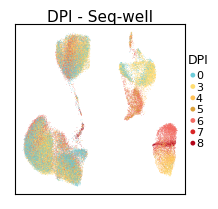

In [21]:
leg_width=.2
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))


ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

umapdata_sorted = umapdata.sort_values(by='DPIc', ascending=False)

ax.scatter(umapdata_sorted['UMAP_1'], umapdata_sorted['UMAP_2'],
           c=umapdata_sorted['dpi_color'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)


legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.4
dpinum = [0, 3, 4, 5, 6, 7, 8]
for (i,y) in enumerate(np.linspace(.7, .3, num=7)):
  legend_ax.scatter(marker_x, y, color=dpimap[dpinum[i]], s=12, edgecolor='None')
  legend_ax.text(marker_x+.15, y-.02, dpinum[i], fontsize=8)
legend_ax.text(.13, .77, 'DPI', fontsize=9, ha='left')

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1, 'DPI - Seq-well', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Invivo.DPI.pdf")
fig.savefig(figure_file, dpi=300)

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


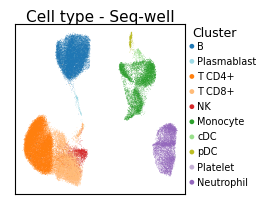

In [22]:
leg_width=.7
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'], c=umapdata['cluster_color'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05

clustering = np.array(['B',  'Plasmablast',  'T CD4+', 'T CD8+',  'NK', 'Monocyte', 'cDC', 'pDC','Platelet', 'Neutrophil'],)

marker_x=.1
N = len(clustering)
for (i,y) in enumerate(np.linspace(.87, .07, num=N)):
  ct = clustering[i]
  legend_ax.scatter(marker_x, y, color=celltype_colors[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)
legend_ax.text(.1, .93, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Cell type - Seq-well', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)

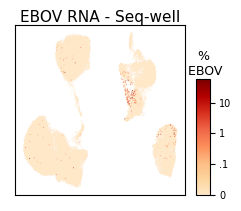

In [23]:
leg_width=.5
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ebov_cmap = LinearSegmentedColormap.from_list(name='ebov_cmap', N=1000,
                                              colors=palettable.colorbrewer.sequential.OrRd_9.mpl_colors[1:])

umapdata_sorted = umapdata.sort_values(by='log10_EBOV_TPT_Clean', ascending=True)

ebov_dotsize=.5
cbarim = ax.scatter(umapdata_sorted['UMAP_1'], umapdata_sorted['UMAP_2'], 
           c=umapdata_sorted['log10_EBOV_TPT_Clean'],
           s=ebov_dotsize, alpha=.7, edgecolor='None', rasterized=True, cmap=ebov_cmap)


#cbar_grid = gs[:, 1].subgridspec(3, 2, wspace=0, hspace=0,
#                                           height_ratios=[1,2,1],
#                                           width_ratios=[.6,1])

cbar_ax = fig.add_axes([.81, .02, .06, .6])

'''
cbar_ax = fig.add_subplot(cbar_grid[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])
'''

fig.colorbar(cbarim, cax=cbar_ax, ticks=[0, 1, 2, 3])

cbar_ax.set_yticklabels(['0', '.1', '1', '10'])
#cbar_ax.set_title('% EBOV')
plt.figtext(.84, .7, '%\n EBOV', fontsize=9, va='center', ha='center')

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'EBOV RNA - Seq-well', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)
figure_file = os.path.join(results_dir, "UMAP.Seqwell.Invivo.EbolaPercent.pdf")

fig.savefig(figure_file, dpi=300)

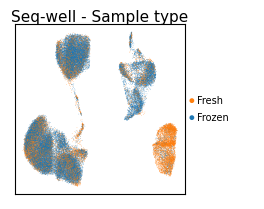

In [24]:
left_space = .04
leg_width=.7
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'], c=umapdata['frz_status_color'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)


legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05

clustering = np.array(['Fresh', 'Frozen'])
frz_thaw_cmap = {'Frozen':c[0], 'Fresh':c[2]}

marker_x=.1
N = len(clustering)
for (i,y) in enumerate(np.linspace(.55, .45, num=N)):
  ct = clustering[i]
  legend_ax.scatter(marker_x, y, color=frz_thaw_cmap[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Seq-well - Sample type', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Invivo.FrzStatus.pdf")

fig.savefig(figure_file, dpi=300)

In [25]:
vc = umapdata['sample'].value_counts()

np.random.seed(14)
maxcells = 500
downsample_list = []
for s in vc.index:
    if vc.at[s]>maxcells:
        selected = list(np.random.choice(umapdata.index[umapdata['sample']==s], size=maxcells, replace=False))
        downsample_list += selected
    else:
        downsample_list += list(umapdata.index[umapdata['sample']==s])

umapdata_downsample = umapdata.loc[downsample_list, :]

Trying to set attribute `.uns` of view, copying.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


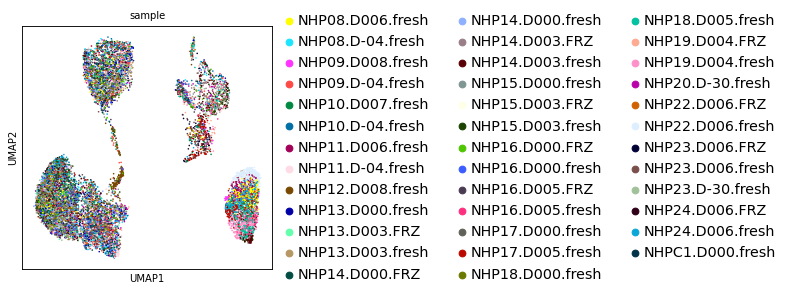

In [26]:
adata_downsample = adata[umapdata_downsample.index, :]
sc.pl.umap(adata_downsample, color=['sample'])

In [27]:
samps = adata_downsample.obs['sample'].cat.categories
samp_colors = adata_downsample.uns['sample_colors']
samp2color_map = dict(zip(samps, samp_colors))
umapdata_downsample['sample_colors'] = umapdata_downsample['sample'].replace(samp2color_map)

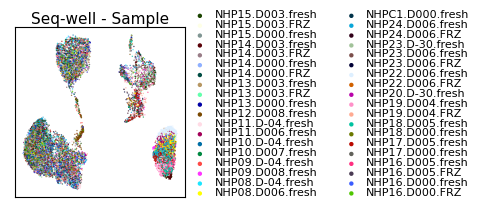

In [28]:
left_space = .02

leg_width=3
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(umapdata_downsample['UMAP_1'], umapdata_downsample['UMAP_2'],
           c=umapdata_downsample['sample_colors'],
           s=1, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[:, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
ncols = 2
numpercol = int(np.ceil(len(samps) / ncols))


count = 0
yposopt = np.linspace(0.02, 0.98, numpercol)
textoffset = .05
xoffset = .05
for s in samps:
  xpos=xoffset+(np.floor(count / numpercol)/ncols)*1.01
  y = yposopt[count % numpercol]
  legend_ax.scatter(xpos, y, color=samp2color_map[s], s=10, edgecolor='None')
  legend_ax.text(xpos+textoffset, y-.01, s, fontsize=8)
  count += 1


title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 0.5, 'Seq-well - Sample', va='center', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Invivo.SampleWithFrz.pdf")
fig.savefig(figure_file, dpi=300)

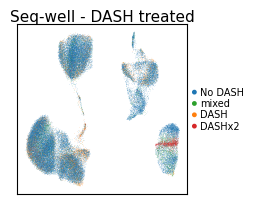

In [116]:
left_space = .04

leg_width=.7
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'], c=umapdata['dash_status_color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)


legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05



marker_x=.1
N = len(dash_status_clean)
for (i,y) in enumerate(np.linspace(.6, .4, num=N)):
  ct = dash_status_clean[i]
  legend_ax.scatter(marker_x, y, color=dash_status_map[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Seq-well - DASH treated', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Invivo.DASH.pdf")
fig.savefig(figure_file, dpi=300)

## Marker plot

In [120]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [121]:
adata_dot = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)

In [122]:
adata_dot = adata_dot[:,~(adata_dot.var['Combined_Blacklist'])]

sc.pp.normalize_per_cell(adata_dot, counts_per_cell_after=1e4)
sc.pp.log1p(adata_dot)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [123]:
adata_dot.obs.columns

Index(['batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status',
       'sample_source', 'sample', 'array_num', 'array_id', 'animal',
       'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP',
       'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short',
       'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes',
       'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito',
       'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden',
       'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2',
       'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet',
       'Subclustering_reduced', 'Soup_Usage', 'ebola_infection_threshold',
       'Ebola_Positive'],
      dtype='object')

In [124]:
adata_dot.obs['Subclustering_clean'] = adata_dot.obs['Subclustering_reduced'].replace({'Tc': 'T CD8+', 'Th': 'T CD4+', 'Neut':'Neutrophil', 'Mono':'Monocyte'})


In [125]:
expression_full = pd.DataFrame(adata_dot.X.todense(), index=adata_dot.obs.index, columns=adata_dot.var.index)
expression_full.rename(columns={'ENSMMUG00000015202':'IGHG'}, inplace=True)

genes_to_plot = ['CD79B','MS4A1', 'IGHG', 'MZB1', 'CD3D', 'IL7R', 'GZMB', 'KLRB1','FCGR3', 'CFD','CD163', 'IRF8','FLT3', 'MAMU-DPA',
               'CD177', 'LCN2']


celltype_order = ['B', 'Plasmablast', 'T CD4+', 'T CD8+', 'NK', 'Mono','cDC', 'pDC',  'Neut']

expression = expression_full.loc[:, genes_to_plot]

adata_dot.obs['Grouped_Clustering'] = pd.Categorical(adata_dot.obs['Subclustering_reduced'].replace({'Tc':'T CD8+', 'Th':'T CD4+'}).values,
                                                    categories=['B', 'Plasmablast', 'T CD8+', 'T CD4+', 'NK', 'Mono','cDC', 'pDC',  'Neut'])

obs = adata_dot.obs.copy()

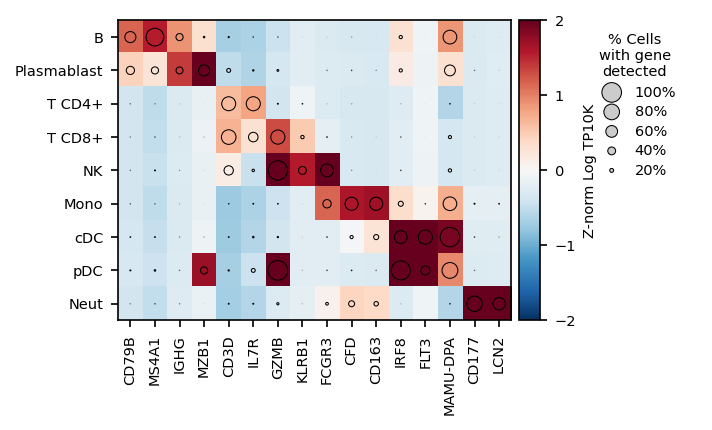

In [126]:
percent_positive = expression.groupby(obs['Grouped_Clustering']).agg(lambda x: (x>0).mean())

expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(adata_dot.obs['Grouped_Clustering']).mean()

width=4.6
heatmap_width=3.8
legend_width=1.8
left_space=.15

heatmap_height = 2.
bottom_space = .7
top_space = .1
height=heatmap_height+bottom_space+top_space

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

alldotsize = percent_positive.copy()
alldotsize = alldotsize - alldotsize.min().min()
alldotsize = alldotsize / alldotsize.max().max()
alldotsize = (alldotsize * 9.4) ** 2

allcolors = average_expression.copy()
vmin=-2.
vmax=2.
cmap = "RdBu_r"

cim= heatmap_ax.imshow(allcolors.loc[celltype_order, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order)))
heatmap_ax.set_yticklabels(celltype_order)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)

for (x, g) in enumerate(genes_to_plot):
    for (y, ct) in enumerate(celltype_order):
        dotsize = alldotsize.loc[ct,g]
        heatmap_ax.scatter(x, y, color="none", marker='o',
                                      s=dotsize, norm=None,
                                       edgecolor='k', linewidth=.5)

        
        
        

plt.colorbar(cim, cax=cbar_ax, ticks=[-2, -1, 0, 1, 2])
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * 9.4) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .25

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.5, .76, 5)

sizelegendfontsize = 7
size_legend_ax.scatter(leg_x, leg_y, s=leg_dot_size, edgecolor='k',  linewidth=.5, c='.8')
size_legend_ax.text(0, .5, 'Z-norm Log TP10K', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)
for i in range(5):
    size_legend_ax.text(leg_x[i]+text_offset, leg_y[i], ('%d' % (100*vals[i])) + '%', fontsize=sizelegendfontsize, va='center')
size_legend_ax.text(.45, .96, '% Cells\nwith gene\ndetected', ha='center', va='top', fontsize=sizelegendfontsize)
    
    
figure_file = os.path.join(results_dir, "CellTypeMarker.Invivo.Seqwell.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)
